In [16]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [17]:


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3837084983576453454
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1600921812944826270
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12267880256387672780
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7464691303
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11412541259744972531
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [18]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import tensorflow as tf
import re
import numpy as np
import Image
from sklearn.model_selection import train_test_split
%matplotlib inline

In [31]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [4]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))


[[ 22.  28.]
 [ 49.  64.]]


In [5]:
from keras import backend as k
from keras.layers import Activation
from keras.layers import Input, Dense, Lambda, Dropout, Convolution2D, MaxPooling2D, Flatten,Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.utils import to_categorical


Using TensorFlow backend.


# Let's read the data

In [20]:
train_file = loadmat('../STL10/stl10_matlab/train.mat')
test_file = loadmat('../STL10/stl10_matlab/test.mat')

print("Train File :" ,train_file.keys())
print("Test File :",test_file.keys())

('Train File :', ['__header__', '__globals__', 'fold_indices', 'y', 'X', '__version__', 'class_names'])
('Test File :', ['__header__', '__globals__', 'y', 'X', '__version__', 'class_names'])


In [21]:
train_images = train_file['X'] #5000 training images ((5000, 27648))
test_images = test_file['X'] #8000 test images ((8000, 27648))
# print(train_images.shape)
print(test_images.shape)
train_labels = train_file['y']
test_labels = test_file['y']
# print(train_labels.shape) #5000 labels for 5000 images ((5000,1))
# print(min(train_labels),max(train_labels)) #class labels go from 1-10.


#Let's re-adjust the labels to be from 0 to 9
train_labels_adjusted = train_labels - 1
test_labels_adjusted = test_labels - 1
# print(min(train_labels_adjusted),max(train_labels_adjusted)) #Class labels adjuested goes from 0 to 9


(8000, 27648)


In [22]:
del train_file,test_file

(5000, 96, 96, 3)
(8000, 96, 96, 3)
(96, 96, 3)


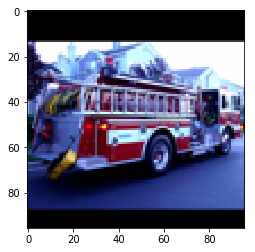

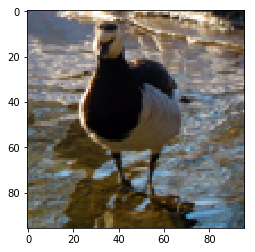

In [23]:
train_images_reshaped = np.transpose(np.reshape(train_images,(-1,3,96,96)),(0,3,2,1))
#-1 lets numpy determine the size on its own
test_images_reshaped = np.transpose(np.reshape(test_images,(-1,3,96,96)),(0,3,2,1))

print(train_images_reshaped.shape)
print(test_images_reshaped.shape)

print(train_images_reshaped[5].shape) #images is 96x96 with 3 colored channels
imshow(train_images_reshaped[5])
plt.show()
imshow(test_images_reshaped[5])

In [24]:
del train_images,test_images

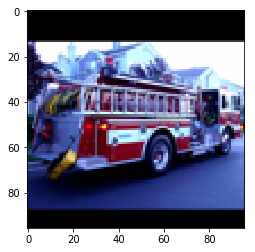

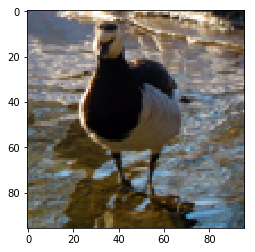

In [25]:
imshow(train_images_reshaped[5])
plt.show()
imshow(test_images_reshaped[5])

In [26]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('test_labels_adjusted', 8112),
 ('train_labels_adjusted', 5112),
 ('test_images_reshaped', 144),
 ('train_images_reshaped', 144),
 ('imshow', 120),
 ('loadmat', 120),
 ('train_test_split', 120),
 ('test_labels', 112),
 ('train_labels', 112),
 ('a', 64),
 ('b', 64),
 ('c', 64),
 ('sess', 64),
 ('device_lib', 56),
 ('np', 56),
 ('plt', 56),
 ('tf', 56)]

In [34]:
import os, sys, tarfile, time
start = time.time()
from PIL import Image

def resize_tensorimages(X_raw, interp_method=Image.BICUBIC):
    # VGG16 accepts input images of size (224, 224, 3)
    # Therefore, convert X_train_raw and X_test_raw to PIL.Image format, 
    # then resize the images from (96, 96, 3) to (224, 224, 3) 
    
    X_224 = np.zeros((X_raw.shape[0], 224, 224, 3))
    for i, _ in enumerate(X_raw):
        im = Image.fromarray(np.uint8(X_raw[i]))
        img = im.resize((224, 224), interp_method)
        X_224[i] = img
    
    return X_224
X_train  = resize_tensorimages(train_images_reshaped)
del train_images_reshaped

print_runtime(start)

MemoryError: 

In [28]:
print(X_test.shape)

(8000, 224, 224, 3)


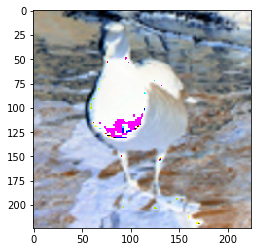

In [32]:
imshow(X_test[5])



In [29]:
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('X_test', 9633792144),
 ('test_labels_adjusted', 8112),
 ('train_labels_adjusted', 5112),
 ('train_images_reshaped', 144),
 ('imshow', 120),
 ('loadmat', 120),
 ('resize_tensorimages', 120),
 ('train_test_split', 120),
 ('test_labels', 112),
 ('train_labels', 112),
 ('a', 64),
 ('b', 64),
 ('c', 64),
 ('sess', 64),
 ('device_lib', 56),
 ('np', 56),
 ('plt', 56),
 ('tf', 56),
 ('x', 38),
 ('start', 24)]

# If we are to use VGG16 we need to resize the images

In [51]:
test_images_vgg= resize_tensorimages(test_images_reshaped)
del test_images_reshaped
print(test_images_vgg.shape)

MemoryError: 

In [42]:
train_images_vgg= resize_tensorimages(train_images_reshaped)
del train_images_reshaped
print(train_images_vgg.shape)


(5000, 224, 224, 3)


In [43]:
test_images_vgg= resize_tensorimages(test_images_reshaped)
del test_images_reshaped
print(test_images_vgg.shape)

MemoryError: 

# Convert the training labels to categorical

In [11]:
y_train_categorical = to_categorical(train_labels_adjusted,num_classes =10)
y_train_categorical_VGG = to_categorical(train_labels_adjusted,num_classes=1000)
print(train_labels_adjusted.shape,y_train_categorical.shape)
print(y_train_categorical[5]) #gives correct one hot encoding, truck is the last class label

((5000, 1), (5000, 10))
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


In [12]:
with open('../STL10/stl10_binary/class_names.txt','r') as f:
    cnames = f.read()
cnames = cnames.split('\n')[:-1]
cnames = np.asarray(cnames) #convert class labels from list to array
print(cnames)

['airplane' 'bird' 'car' 'cat' 'deer' 'dog' 'horse' 'monkey' 'ship' 'truck']


### Change the one hot encoding to be categorical

In [13]:
'''
1. Get the argmax for each row in the one hot encoder
2. Create a set of the output in #1. This will give classes from 0 to 9
3. Loop through the set
4. Whenever #1 is same as the class being currently looped through, append that index to idx
5. We will get a 10,500 array i.e. 500 indices per class for a total of 5000 indices
'''


y = np.argmax(y_train_categorical_VGG,axis = 1)
# print(y[5]) #prints the last class which is truck and is correct
# print(max(y),min(y)) #Goes from 0 to 9 which is 10 classes
# print(set(y)) #creates a set of the classes

idx = []
for cls in set(y): #for each class label, get the indices where encoding is hot for that class
    idx.append(np.where(y==cls)[0])

# print(len(idx)) #length is 10, i.e. we get indices of images for each class
# print(len(idx[0])) #500 images
# print(len(idx[1])) #500 images
# print(len(idx[2])) #500 images

# print(type(idx)) #current dtype is list so lets convert to array
idx = np.asarray(idx)
# print(idx.shape) #10,500. We get 500 images for each class  for a total of 5000 images.
# print(type(idx))


# Now we will create our own folds for training the model

In [14]:
#
#We want to shuffle the indices for each class
'''
1.Remember that idx stored 500 ORDERED indices for each class label
2.We will first shuffle the indices for each class
3.Then let's create 5 folds per class so that we get 100 images per class per fold
'''


for num_class in range(len(idx)):
    np.random.shuffle(idx[num_class])
    
fold_idx = []
num_folds = 5
images_per_class = idx.shape[1]
fold_width = int(images_per_class/num_folds) #100 images per fold for each class i.e. 100x10 images per fold


for fold in range(num_folds):
    out = [] #fresh array for a fold
    for num_class in range(len(idx)):
        out.append(idx[num_class,fold*fold_width:(fold+1)*fold_width])
        #gets 100 images per class
    #at this stage out has 1000 images for a new fold
    np.random.shuffle(out)
    fold_idx.append(out)

fidx = np.array(fold_idx)
print(fidx.shape) # 5 folds, 10 classes per fold and 100 images per class
np.random.shuffle(fidx)

(5, 10, 100)


In [15]:
#Let's check by getting an index for the truck class
print(fidx[0,9][0])
print(fidx[0,9][1])

4852
2284


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. 

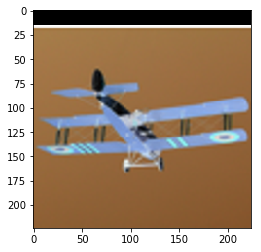

In [24]:
imshow(images_train_vgg[1039])
print(y_train_categorical[1039])
print(y_train_categorical_VGG[1039])

In [19]:
print(y_train_categorical[0])
print(y_train_categorical_VGG[0])

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. 

In [20]:
print(y.shape)

(5000,)


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


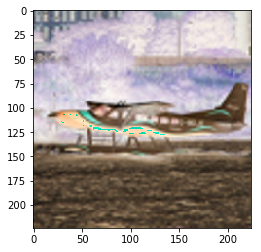

In [25]:
imshow(images_train_vgg[2723])
print(y_train_categorical[2723])

In [21]:
print(fidx[1,9][0])
print(fidx[1,9][1])

364
1458


(224, 224, 3)
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


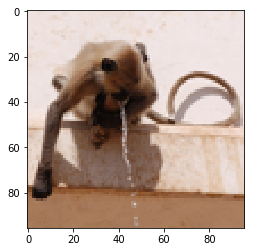

In [27]:
imshow(train_images_reshaped[2884])
print(images_train_vgg[2884].shape)
print(y_train_categorical[2884])

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


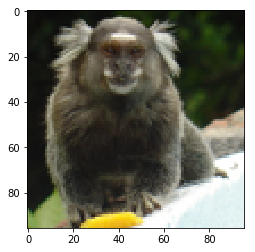

In [23]:
imshow(train_images_reshaped[2486])
print(y_train_categorical[2486])

In [30]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

model_bottom = VGG16(include_top=False)

58900480/58889256 [==============================] - 2s 0us/step


In [227]:
model = Sequential()
model.add(Conv2D(64,kernel_size=3,activation='relu',input_shape=(224,96,3)))
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=3,activation='relu'))
model.add(Conv2D(128,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,kernel_size=3,activation='relu'))
model.add(Conv2D(256,kernel_size=c3,activation='relu'))
model.add(Conv2D(256,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [228]:
model.fit(train_images_reshaped,y_train_categorical,validation_split=0.2,epochs=5,batch_size=128, verbose=2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
 - 317s - loss: 14.1324 - acc: 0.0973 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 2/5
 - 316s - loss: 14.5023 - acc: 0.1003 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 3/5
 - 316s - loss: 14.5023 - acc: 0.1003 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 4/5
 - 316s - loss: 14.5023 - acc: 0.1003 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 5/5
 - 316s - loss: 14.5023 - acc: 0.1003 - val_loss: 14.5224 - val_acc: 0.0990


In [10]:
fold_indices = train_file['fold_indices']
fold_indices_vector = np.squeeze(np.asarray(fold_indices))

In [11]:
print(fold_indices.shape)
print(fold_indices_vector.shape)

(1, 10)
(10,)


In [12]:
print(fold_indices[0,0].shape)
print(fold_indices_vector[0].shape)
fold_array_vector_squeezed = np.squeeze(np.asarray(fold_indices[0,0]))
print(fold_array_vector_squeezed.shape)


(1000, 1)
(1000, 1)
(1000,)


In [13]:
for i in range(10):
    print(min(fold_indices_vector[i]),max(fold_indices_vector[i]),len(fold_indices_vector[i]))


(array([1], dtype=uint16), array([4994], dtype=uint16), 1000)
(array([2], dtype=uint16), array([4995], dtype=uint16), 1000)
(array([14], dtype=uint16), array([4996], dtype=uint16), 1000)
(array([1], dtype=uint16), array([5000], dtype=uint16), 1000)
(array([1], dtype=uint16), array([4986], dtype=uint16), 1000)
(array([3], dtype=uint16), array([4999], dtype=uint16), 1000)
(array([1], dtype=uint16), array([5000], dtype=uint16), 1000)
(array([2], dtype=uint16), array([4999], dtype=uint16), 1000)
(array([8], dtype=uint16), array([4999], dtype=uint16), 1000)
(array([4], dtype=uint16), array([4999], dtype=uint16), 1000)


In [14]:
train_images_fold = np.zeros_like(np.vstack((train_images_reshaped,train_images_reshaped)))
class_labels_fold = np.zeros_like(np.vstack((class_labels,class_labels)))


print(train_images_fold.shape)
print(class_labels_fold.shape)

(10000, 96, 96, 3)
(10000, 1)


In [15]:
print(class_labels.shape)
print(class_labels[0].shape)
print(min(class_labels),max(class_labels))

(5000, 1)
(1,)
(array([1], dtype=uint8), array([10], dtype=uint8))


In [16]:
for i in range(10):
    #Let's create 1000x10 folds into a new train_image_dataset
    start_index = (i*1000) # 0,1000, 2000,...,9000
    end_index = (i*1000)+1000 #999,1999,....9999
    fold_array_vector_squeezed = np.squeeze(np.asarray(fold_indices[0,i]))
    fold_array_vector_squeezed_new = np.subtract(fold_array_vector_squeezed, 1)
    train_images_fold[start_index:end_index,:,:,:] = train_images_reshaped[fold_array_vector_squeezed_new]
    class_labels_fold[start_index:end_index,:] = class_labels[fold_array_vector_squeezed_new]
    

[7]


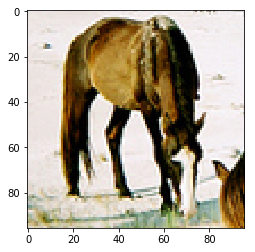

In [17]:
print(class_labels_fold[11])
imshow(train_images_fold[11])


[7]


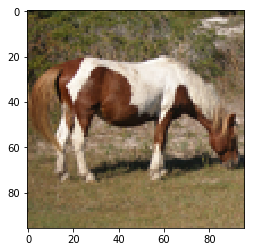

In [27]:
image_index=12
print(class_labels_fold[image_index])
imshow(train_images_fold[image_index])

In [55]:
x_train, x_test, y_train, y_test = train_test_split(train_images_fold,class_labels_fold,test_size = 0.25)

In [57]:
x_train.shape
x_train[0].shape

(96, 96, 3)

In [58]:
x_train_blackwhite = x_train[:,:,:,0]
x_train_blackwhite.shape

(7500, 96, 96)

(96, 96, 3)


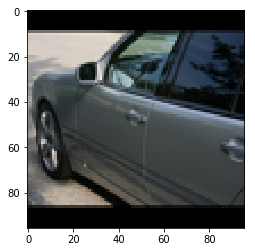

In [59]:
print(x_train[0].shape)
imshow(x_train[0])

(96, 96)


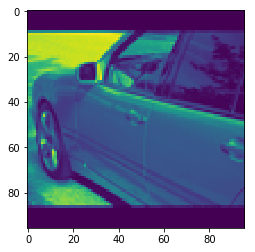

In [60]:
print(x_train_blackwhite[0].shape)
imshow(x_train_blackwhite[0])

In [61]:
print(x_train.shape)

(7500, 96, 96, 3)


In [64]:
y_train_adjusted = np.subtract(y_train,1)
print(max(y_train_adjusted))


[9]


In [66]:
y_test_adjusted = np.subtract(y_test,1)
print(max(y_test_adjusted))

[9]


In [79]:
model = Sequential()
model.add(Conv2D(20,kernel_size=3,activation='relu',input_shape=(96,96,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [75]:
print(y_test_categorical.shape)
print(y_test.shape)

(2500, 10)
(2500, 1)


In [78]:
print(y_test_adjusted[0:2])
print(y_test_categorical[0:2])

[[7]
 [4]]
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [77]:
y_test_categorical[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.], dtype=float32)

In [80]:
model.fit(x_train,y_train_categorical,validation_split=0.2,epochs=10,batch_size=128, verbose=2)

ValueError: Error when checking target: expected dense_6 to have shape (1,) but got array with shape (10,)

In [244]:
#Now let's build our base network which is a CNN used for feature extraction

#We will build 2 Conv layers with ReLU activations and Max Pooling followed by a flat layer

def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6,12]
    kernel_size = (3,3)
    
    #convolutional layer 1
    seq.add(Conv2D(nb_filter[0],kernel_size=kernel_size,input_shape = input_shape,strides=(1,1),
                          padding = 'valid',activation ='relu'))
#     seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2,2)))
    seq.add(Dropout(0.25))
    
    #convolutional layer 2
    seq.add(Conv2D(nb_filter[1],kernel_size=kernel_size,padding='valid',strides=(1,1),activation='relu'))
#     seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2,2),dim_ordering='th'))
    seq.add(Dropout(0.25))
    
    #flatten
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50,activation='relu'))
    
    return seq
    
    

In [245]:
input_dim = x_train.shape[1:]
input_dim

(96, 96, 3)

In [246]:
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [247]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

/home/aishwarya105/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", pool_size=(2, 2))`


In [248]:
feat_vecs_a.shape[0]

Dimension(None)

In [249]:
#feature vectors are the feature vectors of our input pair. 
#Next we feed these feature vectors into the energy function to compute the distance between them
#We use Euclidean distance between them

def euclidean_distance(vects):
    x,y = vects
    return k.sqrt(k.sum(k.square(x-y),axis = 1, keepdims = True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

#Lambda layer wraps an arbitrary function as a Layer object
distance = Lambda(euclidean_distance, output_shape = eucl_dist_output_shape)([feat_vecs_a,feat_vecs_b])


In [250]:
img_a.shape

TensorShape([Dimension(None), Dimension(96), Dimension(96), Dimension(3)])

In [251]:
epochs = 13
rms = RMSprop()

model = Model(input=[img_a,img_b], output = distance)

/home/aishwarya105/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`
  after removing the cwd from sys.path.


In [252]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return k.mean((y_true) * k.square(y_pred) + (1-y_true) * k.square(k.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer=rms)

In [254]:
print(x_train[0].shape)
print(x_train[1].shape)
print(x_train.shape)

(96, 96, 3)
(96, 96, 3)
(7500, 96, 96, 3)


In [255]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

img_1.shape

(7500, 96, 3)

In [69]:


model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, nb_epoch=epochs)

/home/aishwarya105/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 11250 samples, validate on 3750 samples
Epoch 1/13
 - 17s - loss: 0.0848 - val_loss: 0.1008
Epoch 2/13
 - 17s - loss: 0.0744 - val_loss: 0.1273
Epoch 3/13
 - 17s - loss: 0.0658 - val_loss: 0.0887
Epoch 4/13
 - 17s - loss: 0.0577 - val_loss: 0.0488
Epoch 5/13
 - 17s - loss: 0.0518 - val_loss: 0.0490
Epoch 6/13
 - 17s - loss: 0.0479 - val_loss: 0.0528
Epoch 7/13
 - 17s - loss: 0.0443 - val_loss: 0.0444
Epoch 8/13
 - 17s - loss: 0.0403 - val_loss: 0.0361
Epoch 9/13
 - 17s - loss: 0.0372 - val_loss: 0.0340
Epoch 10/13
 - 17s - loss: 0.0351 - val_loss: 0.0368
Epoch 11/13
 - 17s - loss: 0.0330 - val_loss: 0.0312
Epoch 12/13
 - 17s - loss: 0.0306 - val_loss: 0.0319
Epoch 13/13
 - 17s - loss: 0.0285 - val_loss: 0.0278


In [70]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [71]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [72]:
compute_accuracy(pred, y_test)

0.95199999999999996

In [46]:
#Defining a function to read the image

#QUESTION : Is this really needed? And if so how is the regex working??
def read_image(filename, byteorder = '>'):
    
    #first we read the image as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)",buffer).groups()
        
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                        dtype = 'u1' if int(maxval)<256 else byteorder+'u2',
                        count = int(width)*int(height),
                        offset = len(header)
                        ).reshape((int(height), int(width)))


In [47]:
img = read_image('s1/1.pgm')
img.shape

(112, 92)

In [85]:
import os
from skimage import io
import matplotlib.pyplot as plt


In [49]:
img_os = io.imread('s1/1.pgm')

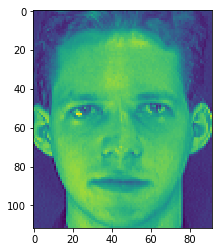

In [50]:
plt.imshow(img_os)

In [51]:
print(img_os.shape)
type(img_os)

(112, 92)


numpy.ndarray

In [52]:
img_os_new = img_os[::2,::2]
img_os_new.shape

(56, 46)

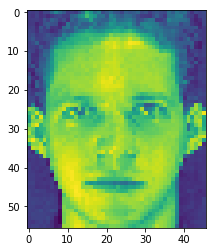

In [53]:
plt.imshow(img_os_new)

In [54]:
#Next we make x_imposite and x_genuine and concatenate to X and we make y_imposite and y_genuine and concatenate to Y

size = 2
total_sample_size = 10000

def get_data(size, total_sample_size):
    #read the image
    image = read_image('s'+str(1)+'/'+str(1)+'.pgm','rw+')
    
    #reduce the size of the image
    #QUESTION : How does this reduce the size of the image?
    #Answer: This skips every other pixel
    image = image[::size, ::size]
    
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]
    
    count = 0
    
    #initialize numpy array with the shape of [total sample, number of pairs, dim1, dim2]
    x_genuine_pair = np.zeros([total_sample_size,2,1,dim1,dim2])
    y_genuine = np.zeros([total_sample_size,1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read two different images from same directory i.e. genuine pair
            while ind1==ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
                
            #read the two images
            img1 = read_image('s'+str(i+1)+'/'+str(ind1+1)+'.pgm','rw+')
            img2 = read_image('s'+str(i+1)+'/'+str(ind2+1)+'.pgm','rw+')
            
            #reduce the size
            img1 = img1[::size,::size]
            img2 = img2[::size,::size]
            
            #store the image to the initialized numpy array
            x_genuine_pair[count,0,0,:,:] = img1
            x_genuine_pair[count,1,0,:,:] = img2
            
            #because we drew from the same directory we assign label 1
            y_genuine[count] = 1
            count += 1
            
    
    count = 0
    
    x_imposite_pair = np.zeros([total_sample_size,2,1,dim1,dim2])
    y_imposite = np.zeros([total_sample_size,1])
    
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pairs). Make sure ind1 is diff from ind2
            while True:
                ind1 = np.random.randint(40) #we will use this to parse through the directories
                ind2 = np.random.randint(40)
                if ind1!=ind2:
                    break
            
            
            img1 = read_image('s'+str(ind1+1)+'/'+str(j+1)+'.pgm','rw+')
            img2 = read_image('s'+str(ind2+1)+'/'+str(j+1)+'.pgm','rw+')
            
            #reduce the size
            img1 = img1[::2,::2]
            img2 = img2[::2,::2]
            
            x_imposite_pair[count,0,0,:,:] = img1
            x_imposite_pair[count,1,0,:,:] = img2
            
            #becauser we are drawing from different directory we assign label as 0
            y_imposite[count] = 0
            count += 1
            
            
            
    #now concatenate the genuine pairs and the composite pairs to get the whole data
    X = np.concatenate([x_genuine_pair,x_imposite_pair],axis = 0)/255
    Y = np.concatenate([y_genuine,y_imposite], axis = 0)
    
    return X,Y
            
            


In [55]:
X,Y = get_data(size,total_sample_size)


In [56]:
X.shape

(20000, 2, 1, 56, 46)

In [57]:
Y.shape

(20000, 1)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25)

In [76]:
x_train.shape

(15000, 2, 1, 56, 46)

In [60]:
x_train.shape

(15000, 2, 1, 56, 46)